In [1]:
import os
import sys
import glob
from collections import defaultdict
from functools import reduce, partial
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy import spatial

from mutspec_utils.annotation import mutations_summary, calculate_mutspec, lbl_id2lbl, lbl2lbl_id
from mutspec_utils.constants import possible_sbs192, possible_sbs12
from mutspec_utils.draw import plot_mutspec192, plot_mutspec192box, plot_mutspec12

In [2]:
color_mapping12 = {
    "C>A": "deepskyblue",
    "G>T": "deepskyblue",
    "C>G": "black",
    "G>C": "black",
    "C>T": "red",
    "G>A": "red",  # salmon
    "T>A": "silver",
    "A>T": "silver",
    "T>C": "yellowgreen",
    "A>G": "yellowgreen",
    "T>G": "pink",
    "A>C": "pink",
}
sbs12_ordered = ["C>A", "G>T", "C>G", "G>C", "C>T", "G>A", "T>A", "A>T", "T>C", "A>G", "T>G", "A>C"]
colors12 = [color_mapping12[sbs] for sbs in sbs12_ordered]

In [3]:
def plot_mutspec12(mutspec: pd.DataFrame, ylabel="MutSpec", title="Full mutational spectrum", figsize=(6, 4), show=True, savepath=None):
    # TODO add checks of mutspec12
    # TODO add description to all plot* functions
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax = sns.boxplot(x="Mut", y=ylabel, data=mutspec, order=sbs12_ordered, ax=fig.gca())

    # map colors to bars
    for bar, clr in zip(ax.patches, colors12):
        bar.set_color(clr)

    ax.set_title(title)
    ax.set_ylabel("")
    ax.set_xlabel("")

    if savepath is not None:
        plt.savefig(savepath)
    if show:
        plt.show()
    else:
        plt.close()
    return ax

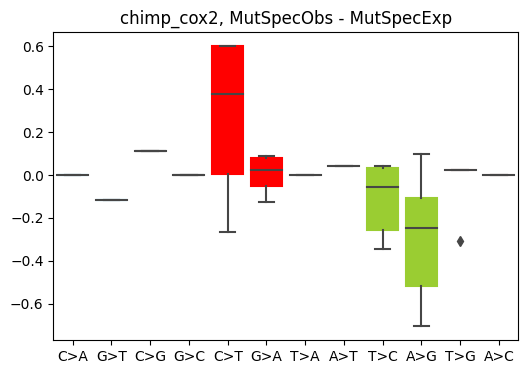

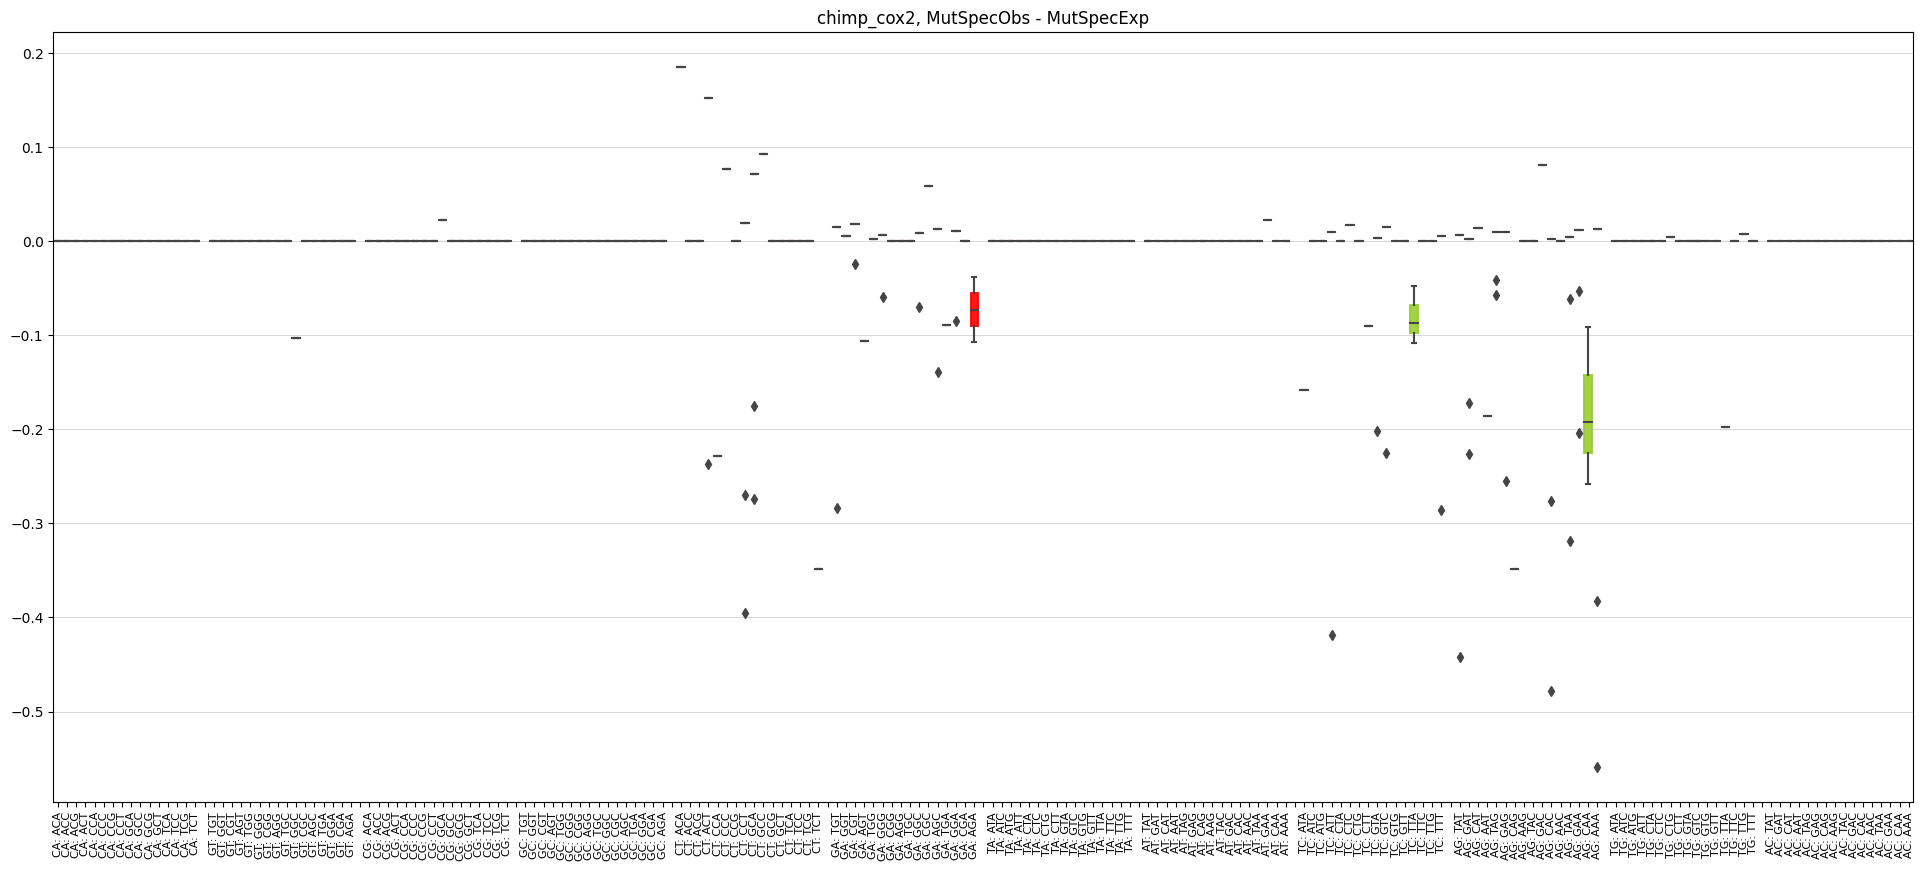

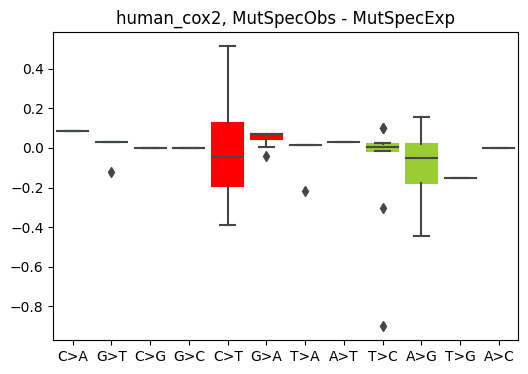

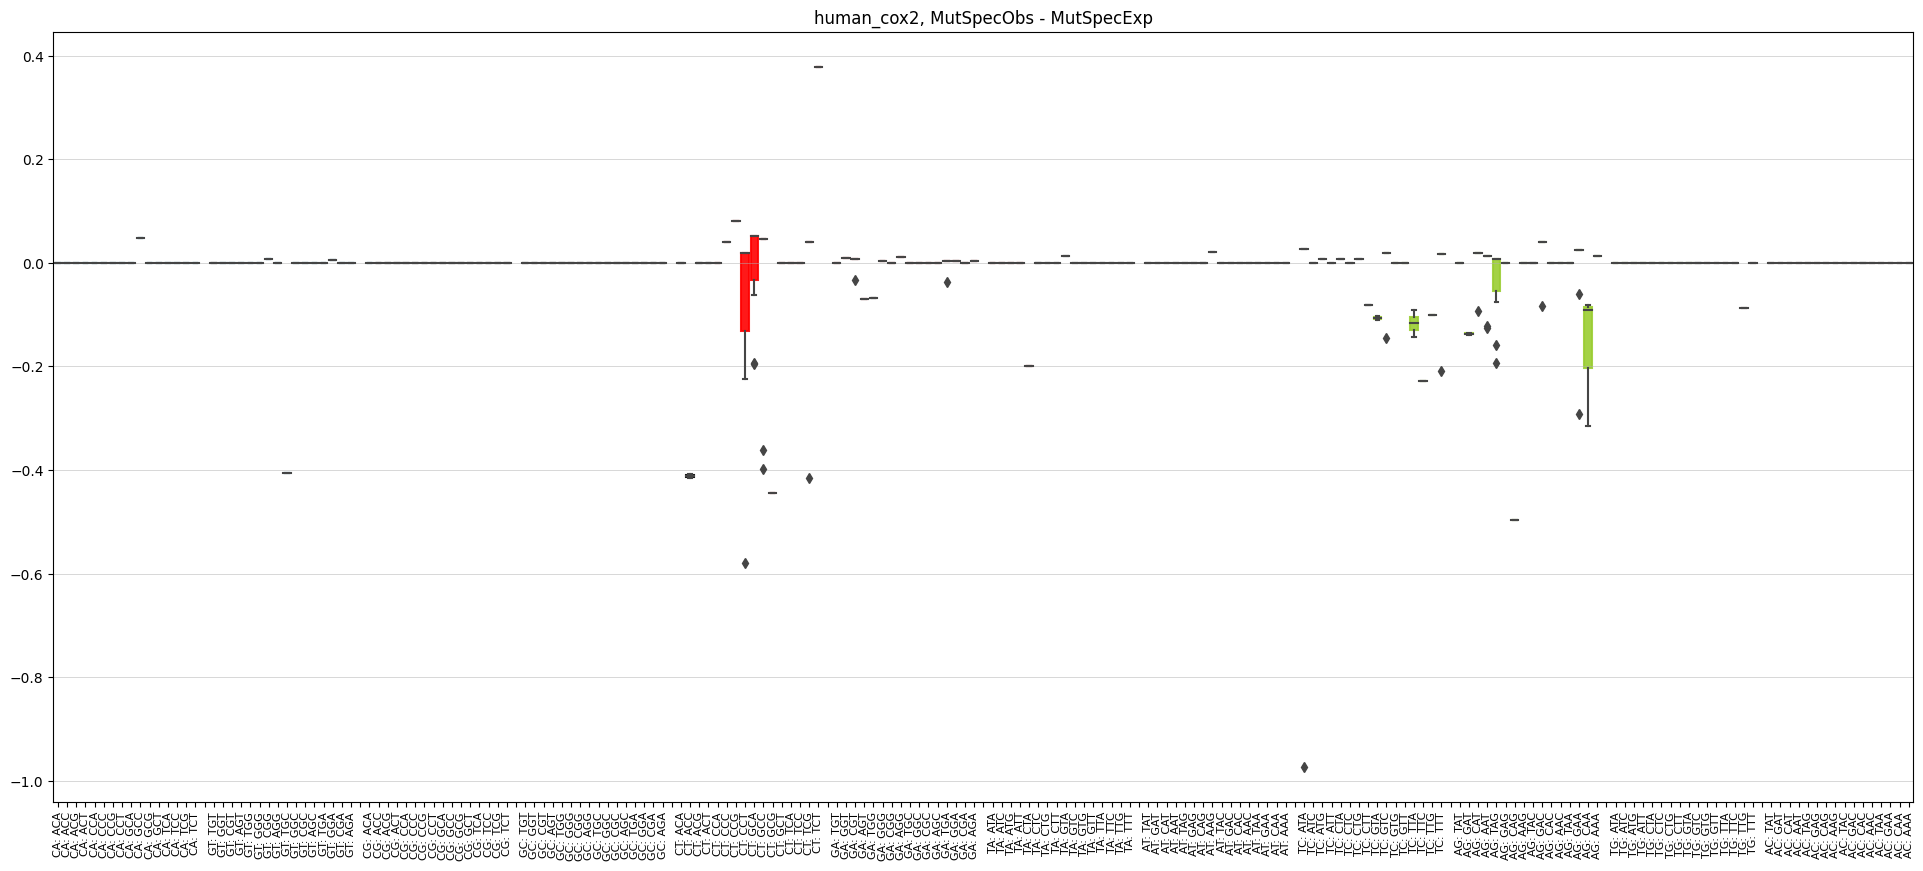

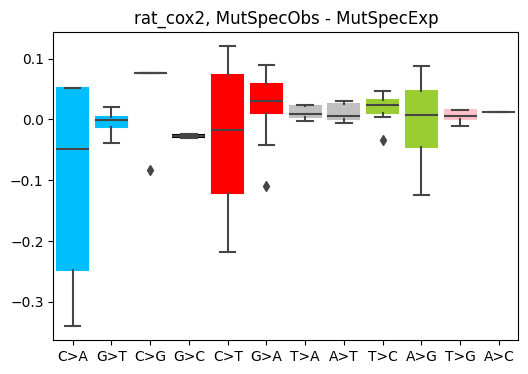

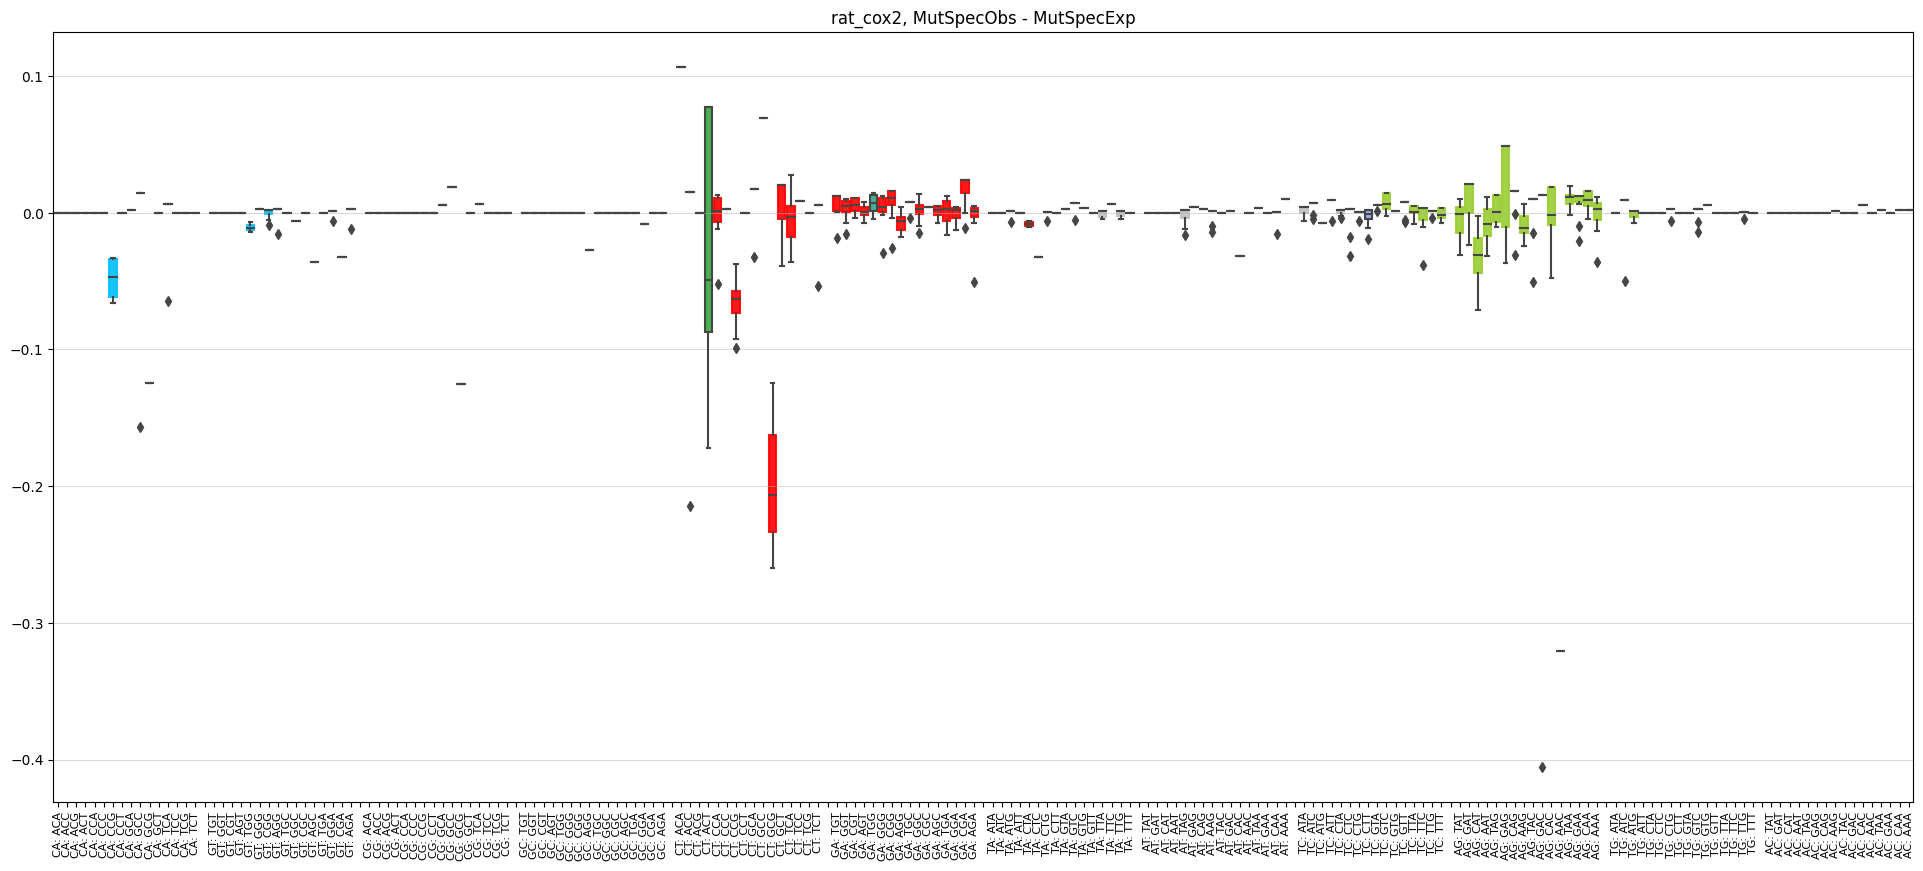

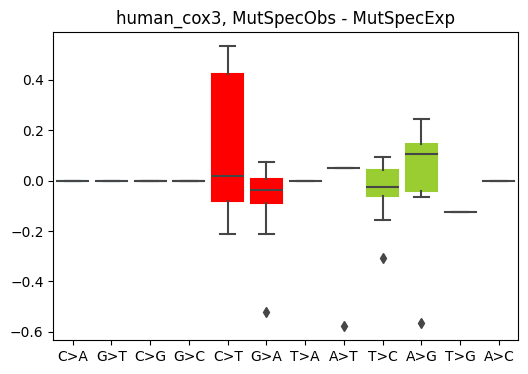

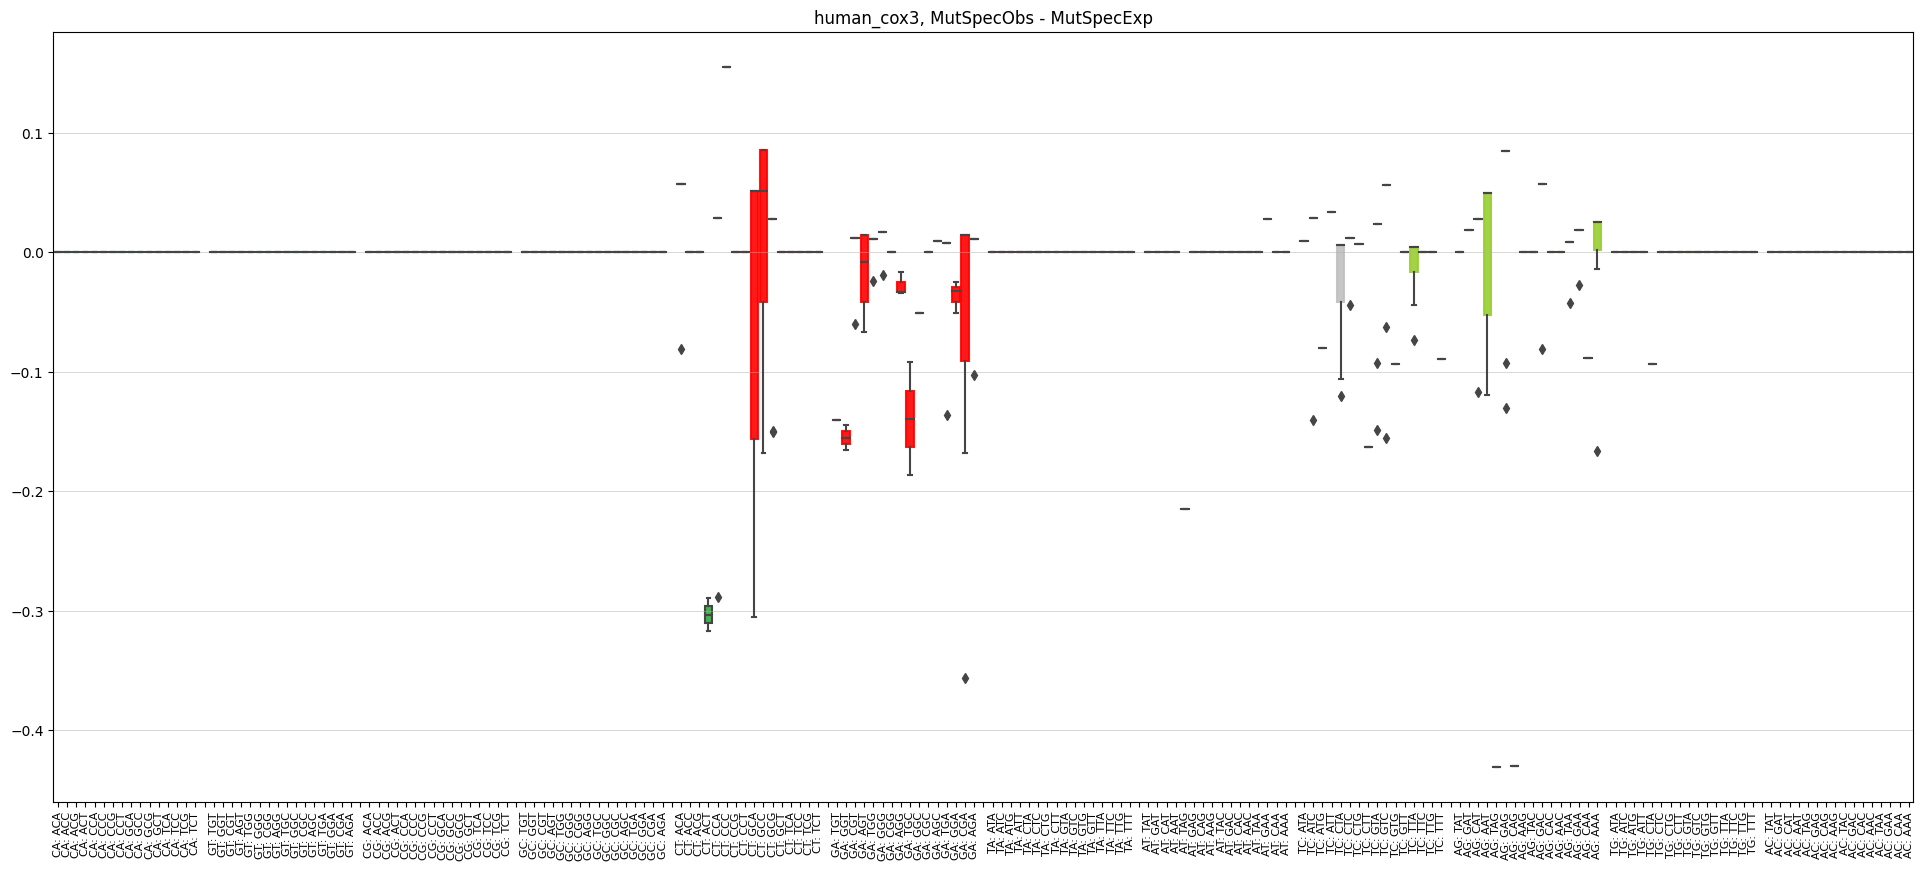

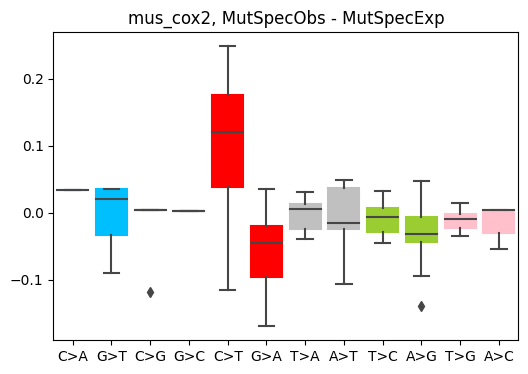

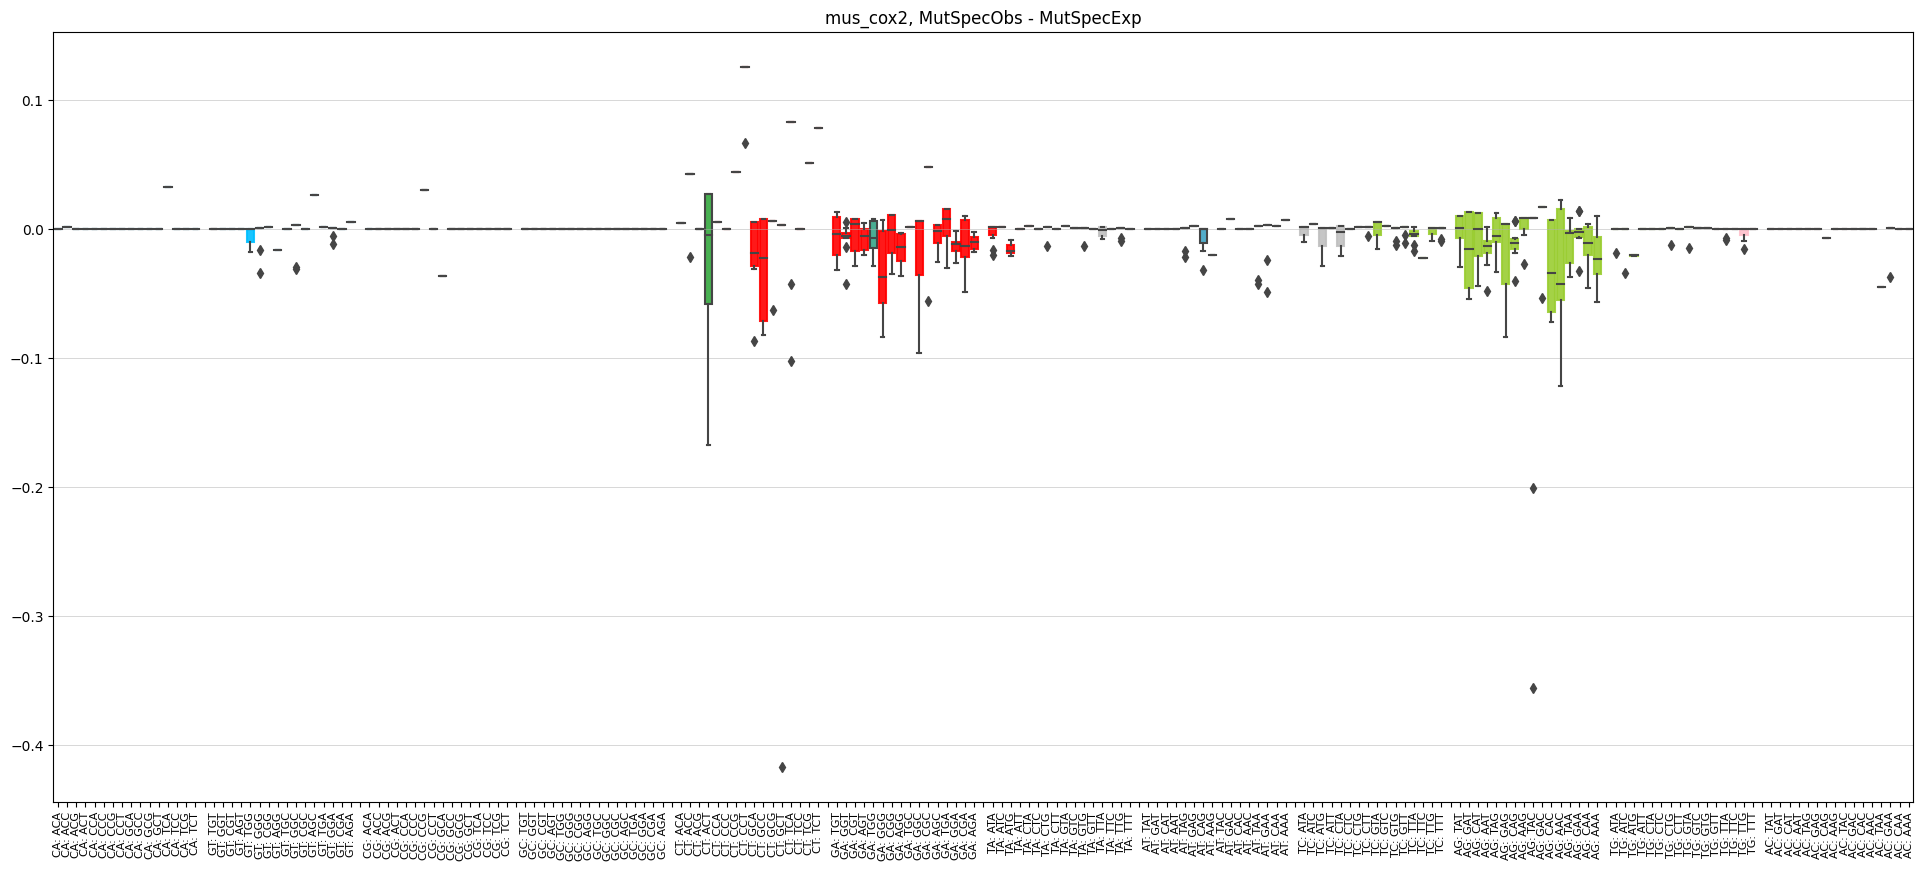

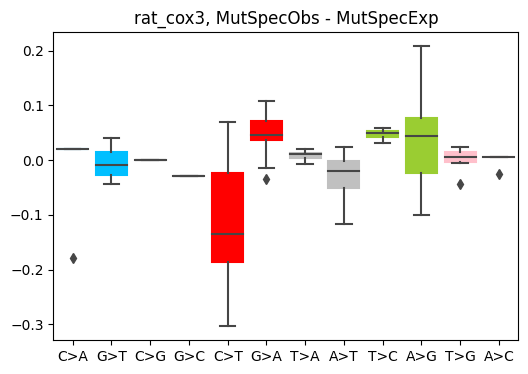

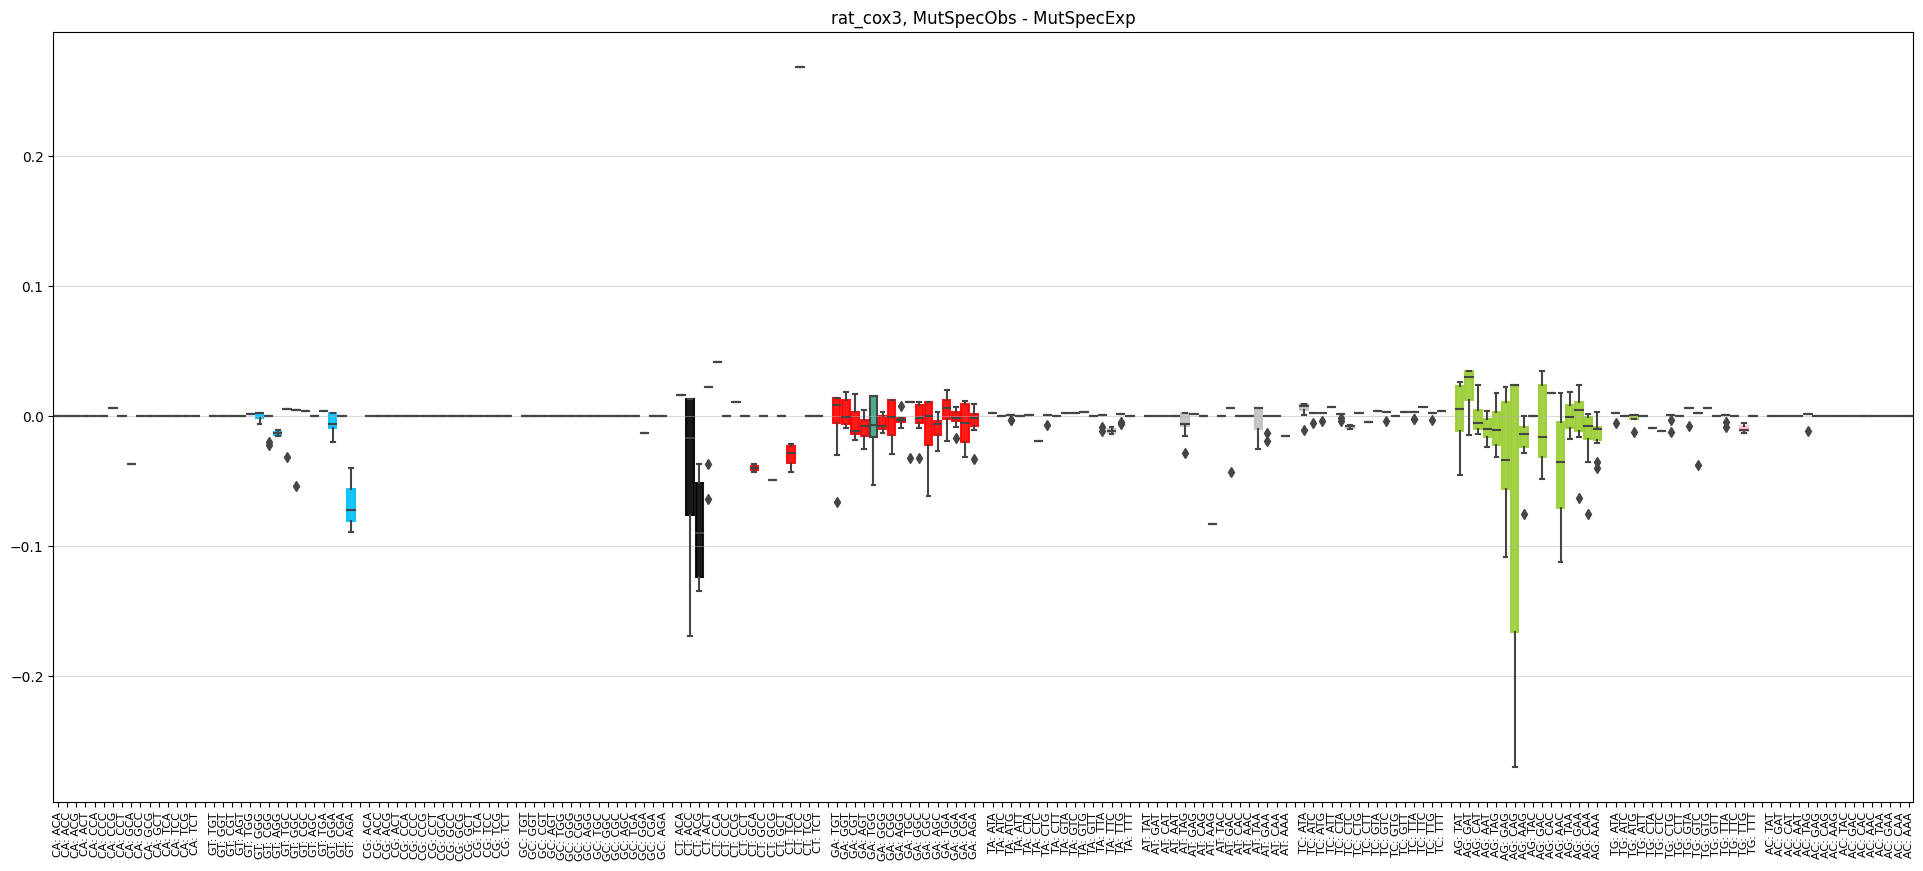

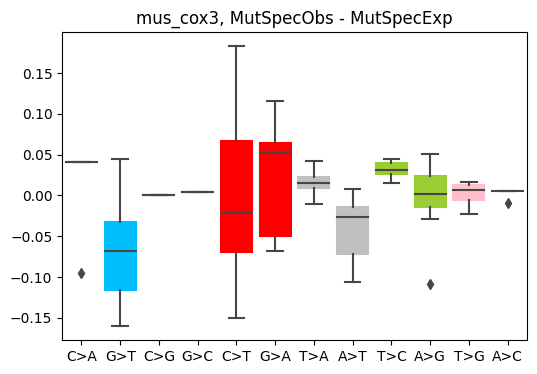

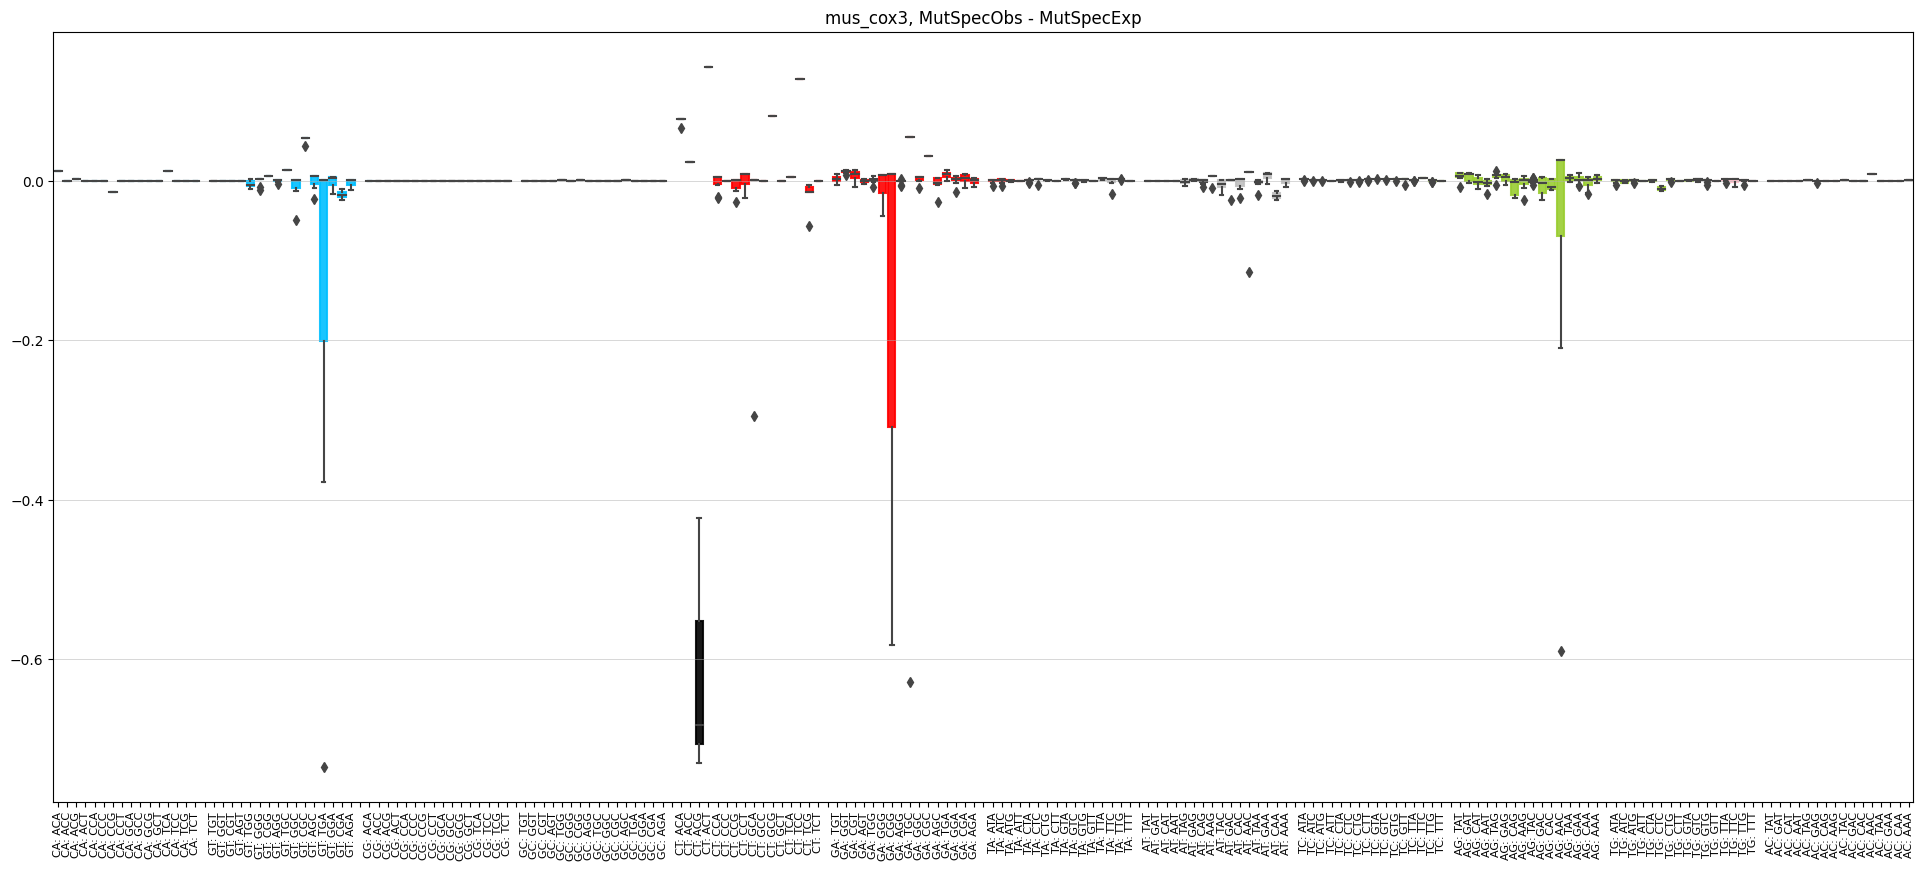

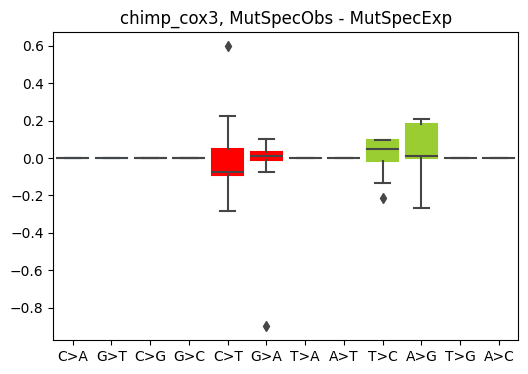

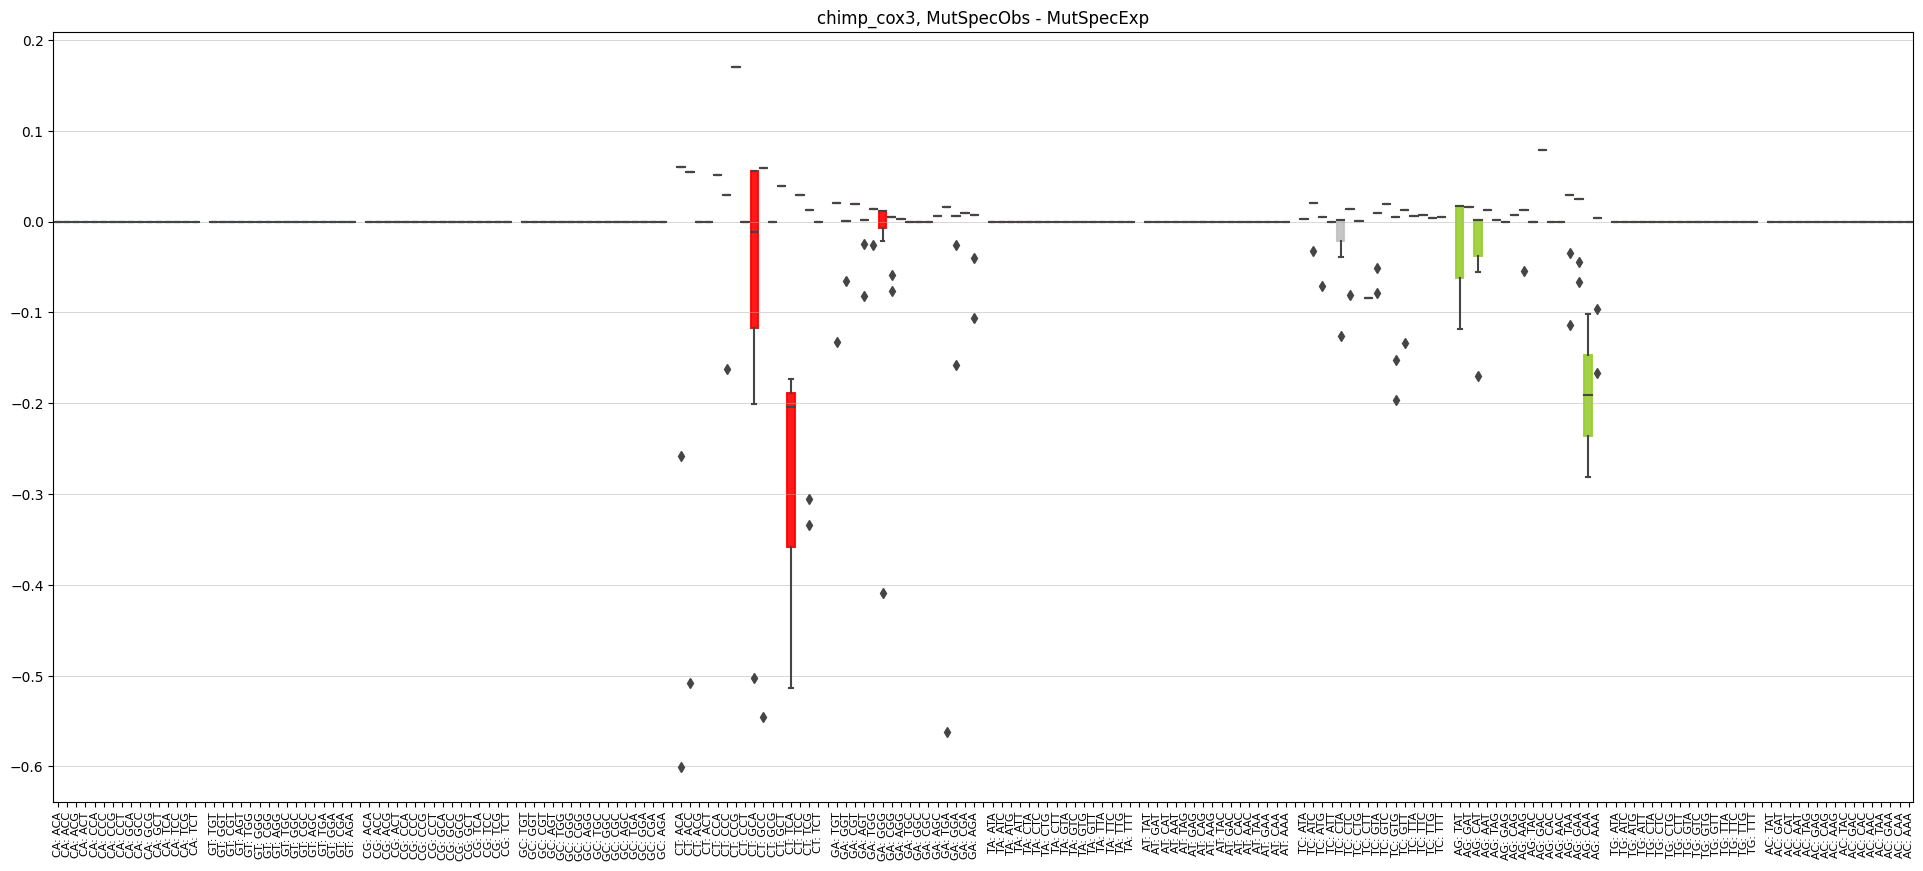

In [5]:
indir = "/home/mr/Downloads/sp_ms"
for d in os.listdir(indir):
    if not os.path.isdir(os.path.join(indir, d)):
        continue
    ms12p = pd.read_csv(os.path.join(indir, d, "ms12syn_iqtree_pyvolve.tsv"), sep="\t")
    ms192p = pd.read_csv(os.path.join(indir, d, "ms192syn_iqtree_pyvolve.tsv"), sep="\t")
    ms12 = pd.read_csv(os.path.join(indir, d, "ms12syn_iqtree.tsv"), sep="\t")
    ms192 = pd.read_csv(os.path.join(indir, d, "ms192syn_iqtree.tsv"), sep="\t")

    df12 = pd.merge(ms12p[["Mut", "MutSpec"]].rename(columns={"MutSpec": "MutSpecExp"}), ms12[["Mut", "MutSpec"]].rename(columns={"MutSpec": "MutSpecObs"}), on="Mut")
    df192 = pd.merge(ms192p[["Mut", "MutSpec"]].rename(columns={"MutSpec": "MutSpecExp"}), ms192[["Mut", "MutSpec"]].rename(columns={"MutSpec": "MutSpecObs"}), on="Mut")

    df12["Diff"] = df12.MutSpecObs - df12.MutSpecExp
    df192["Diff"] = df192.MutSpecObs - df192.MutSpecExp

    df12f = df12[(df12.MutSpecExp > 0) | (df12.MutSpecObs > 0)]
    for sbs in set(df12.Mut.unique()).difference(df12f.Mut.unique()):
        df12f = df12f.append({'Mut': sbs, 'MutSpecExp': 0, 'MutSpecObs': 0, 'Diff': 0}, ignore_index=True)

    df192f = df192[(df192.MutSpecExp > 0) | (df192.MutSpecObs > 0)]
    for sbs in set(df192.Mut.unique()).difference(df192f.Mut.unique()):
        df192f = df192f.append({'Mut': sbs, 'MutSpecExp': 0, 'MutSpecObs': 0, 'Diff': 0}, ignore_index=True)
    
    plot_mutspec12(df12f, "Diff", f"{d}, MutSpecObs - MutSpecExp", savepath=os.path.join(indir, f"diff12_{d}.png"))
    plot_mutspec192box(df192f, "Diff", f"{d}, MutSpecObs - MutSpecExp", filepath=os.path.join(indir, f"diff192_{d}.png"))

    # break